<a href="https://colab.research.google.com/github/maravilla2610/maravilla2610/blob/main/ChronosxKimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets
!pip install torch
!pip install numpy
!pip install pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
   

# Import the breadcrumbs  

In [72]:
import pandas as pd

# Load the csv file
breadcrumbs_df = pd.read_csv('./breadcrumbs_869487061875117.csv')
# Display the first few rows of the DataFrame
breadcrumbs_df.head()

,v,imei,sn,time,lat,lng,device,gsm,position,nearby,kimax,weight
0,1,869487061875117,700001935,1722297144,0,0,"{""fwVersion"":140,""externalVoltage"":28.22999954...","{""ccid"":""8935711001081952076F"",""signal"":17}","{""fix"":false,""satellites"":0,""speed"":0,""course""...",NaN,"[{""cn1"":0,""cn2"":0,""cn3"":0,""cn4"":0},{""cn1"":15.3...","[{""raw"":15.399999618530273,""t"":5.9800000190734..."
1,1,869487061875117,700001935,1722297159,0,0,"{""fwVersion"":140,""externalVoltage"":28.22999954...","{""ccid"":""8935711001081952076F"",""signal"":17}","{""fix"":false,""satellites"":0,""speed"":0,""course""...",NaN,"[{""cn1"":0,""cn2"":0,""cn3"":0,""cn4"":0},{""cn1"":15.3...","[{""raw"":15.399999618530273,""t"":5.9800000190734..."
2,1,869487061875117,700001935,1722297174,0,0,"{""fwVersion"":140,""externalVoltage"":28.22999954...","{""ccid"":""8935711001081952076F"",""signal"":17}","{""fix"":false,""satellites"":0,""speed"":0,""course""...",NaN,"[{""cn1"":0,""cn2"":0,""cn3"":0,""cn4"":0},{""cn1"":15.3...","[{""raw"":15.399999618530273,""t"":5.9800000190734..."
3,1,869487061875117,700001935,1722297189,0,0,"{""fwVersion"":140,""externalVoltage"":28.21999931...","{""ccid"":""8935711001081952076F"",""signal"":17}","{""fix"":false,""satellites"":0,""speed"":0,""course""...",NaN,"[{""cn1"":0,""cn2"":0,""cn3"":0,""cn4"":0},{""cn1"":15.3...","[{""raw"":15.390000343322754,""t"":5.9699997901916..."
4,1,869487061875117,700001935,1722297204,0,0,"{""fwVersion"":140,""externalVoltage"":28.21999931...","{""ccid"":""8935711001081952076F"",""signal"":17}","{""fix"":false,""satellites"":0,""speed"":0,""course""...",NaN,"[{""cn1"":0,""cn2"":0,""cn3"":0,""cn4"":0},{""cn1"":15.3...","[{""raw"":15.390000343322754,""t"":5.9699997901916..."


# Map the most concurred places by the vehicles

In [73]:
import folium
from folium.plugins import HeatMap
import pandas as pd
from IPython.display import display

breadcrumbs_df['lat'] = breadcrumbs_df['lat']
breadcrumbs_df['lng'] = breadcrumbs_df['lng']

# Initialize a map centered around the mean latitude and longitude
mean_lat = breadcrumbs_df['lat'].mean()
mean_lng = breadcrumbs_df['lng'].mean()
m = folium.Map(location=[mean_lat, mean_lng], zoom_start=10)

# Extract coordinates and add them to the map
coords_list = breadcrumbs_df[['lat', 'lng']].values.tolist()

# Add points to the map
for coord in coords_list:
    folium.CircleMarker(location=coord, radius=2, color='blue', fill=True).add_to(m)

# Heatmap layer
heat_map = HeatMap(coords_list)
m.add_child(heat_map)

# Display the map inline
display(m)


# Preprocess the data, we have to label the weight events in order to train the model
## The data currenlty only contains the weight of the vehicle at a particular time

### Convert the time to datetime

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import json
from scipy.signal import savgol_filter

# Convert 'time' field to datetime
breadcrumbs_df['datetime'] = pd.to_datetime(breadcrumbs_df['time'], unit='s')

# Set 'datetime' as the index
breadcrumbs_df.set_index('datetime', inplace=True)

### Extract the total weights at a certian time

In [ ]:
# Function to parse weight data from JSON string
def extract_weights(weight_column):
    extracted_weights = []
    for weights in weight_column:
        try:
            weight_list = json.loads(weights)
            total_weight = sum(item['raw'] for item in weight_list)
        except (json.JSONDecodeError, TypeError):
            total_weight = 0
        extracted_weights.append(total_weight)
    return extracted_weights

# Add a column with extracted weights
breadcrumbs_df['extracted_weight'] = extract_weights(breadcrumbs_df['weight'])


# Initialize dictionaries to store weights and timestamps for each vehicle
all_weights = defaultdict(list)
all_datetimes = defaultdict(list)
all_imeis = defaultdict(list)

# Extract data
for i, row in breadcrumbs_df.iterrows():
    vehicle = row['imei']
    weight = row['extracted_weight']
    row_datetime = i
    all_weights[vehicle].append(weight)
    all_datetimes[vehicle].append(row_datetime)
    all_imeis[vehicle].append(vehicle)

# List of unique vehicles
vehicles = breadcrumbs_df['imei'].unique()

### Resample and smooth the data

In [ ]:

# Resample to 1-minute intervals and smooth the data
def resample_and_smooth_log(df):
    resampled = df.resample('1T').mean()
    # Fill NaN values with forward fill, then backward fill
    resampled = resampled.fillna(method='ffill').fillna(method='bfill')
    # Apply savgol filter
    smoothed_weight = savgol_filter(resampled['weight'], window_length=11, polyorder=2)
    resampled['smoothed_weight'] = smoothed_weight
    return resampled

### Visualize the weight of the vehicle over time

<ipython-input-75-464aa0202fe0>:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled = resampled.fillna(method='ffill').fillna(method='bfill')


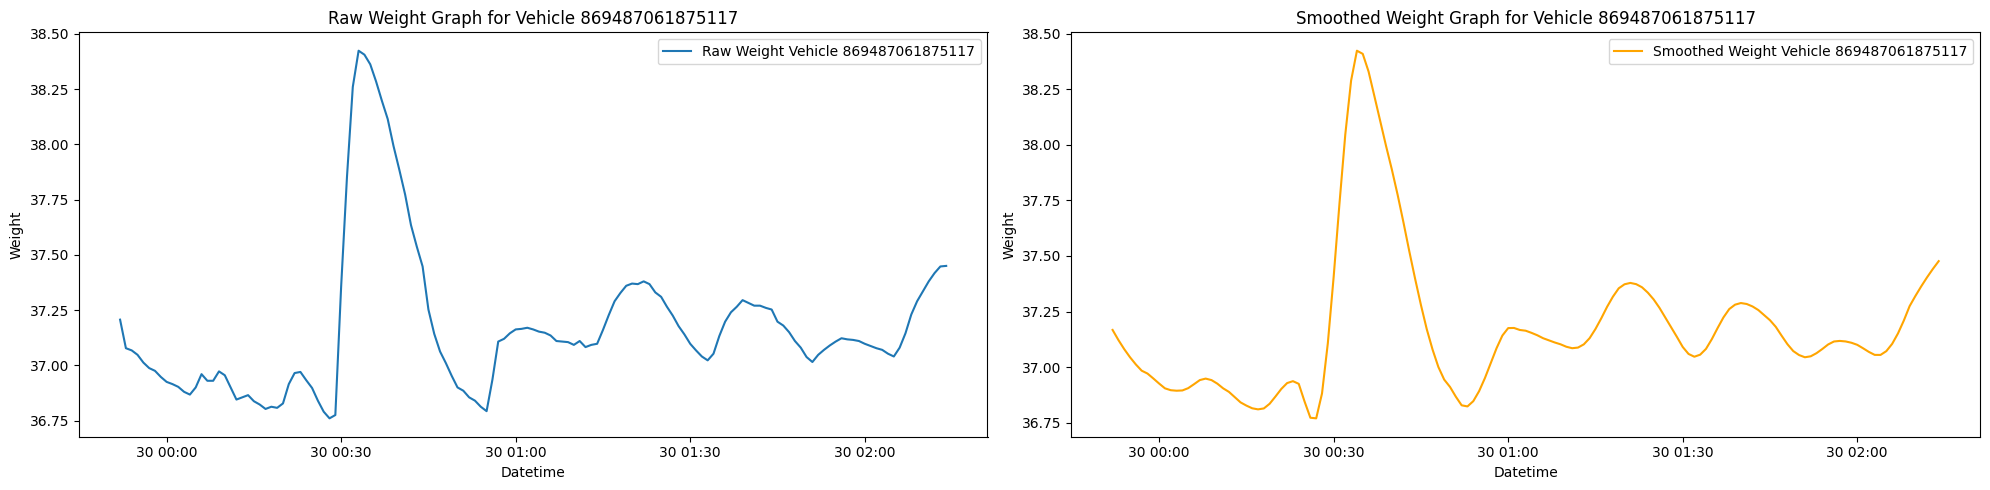

In [75]:

# Plot the raw and smoothed weight graphs for each vehicle
fig, axs = plt.subplots(len(vehicles), 2, figsize=(20, 5 * len(vehicles)))

# Handle the case where there is only one vehicle
if len(vehicles) == 1:
    axs = [axs]

for i, vehicle in enumerate(vehicles):
    vehicle_weights = all_weights[vehicle]
    vehicle_datetimes = all_datetimes[vehicle]

    # Convert lists to pandas DataFrame
    df = pd.DataFrame({'datetime': vehicle_datetimes, 'weight': vehicle_weights, 'imei': all_imeis[vehicle]})
    df.set_index('datetime', inplace=True)
    resampled_df = df.resample('1T').mean()

    # Resample and smooth data
    smoothed_df = resample_and_smooth_log(df)

    # Plot raw data
    axs[i][0].plot(resampled_df.index, resampled_df['weight'], label=f'Raw Weight Vehicle {vehicle}')
    axs[i][0].set_xlabel('Datetime')
    axs[i][0].set_ylabel('Weight')
    axs[i][0].legend()
    axs[i][0].set_title(f'Raw Weight Graph for Vehicle {vehicle}')

    # Plot smoothed data
    axs[i][1].plot(smoothed_df.index, smoothed_df['smoothed_weight'], label=f'Smoothed Weight Vehicle {vehicle}', color='orange')
    axs[i][1].set_xlabel('Datetime')
    axs[i][1].set_ylabel('Weight')
    axs[i][1].legend()
    axs[i][1].set_title(f'Smoothed Weight Graph for Vehicle {vehicle}')

plt.tight_layout()
plt.show()

In [76]:
smoothed_df.head(40)

,weight,imei,smoothed_weight
datetime,,,
2024-07-29 23:52:00,37.206667,8.694871e+14,37.167384
2024-07-29 23:53:00,37.077501,8.694871e+14,37.122015
2024-07-29 23:54:00,37.067501,8.694871e+14,37.080999
2024-07-29 23:55:00,37.047501,8.694871e+14,37.044336
2024-07-29 23:56:00,37.012501,8.694871e+14,37.012026
2024-07-29 23:57:00,36.987501,8.694871e+14,36.984069
2024-07-29 23:58:00,36.975001,8.694871e+14,36.971126
2024-07-29 23:59:00,36.947501,8.694871e+14,36.949063
2024-07-30 00:00:00,36.925001,8.694871e+14,36.926114


## Structure the data for training the algorithm

In [ ]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [82]:
# Define the window size
window_size = 20

# Calculate the rolling sum for windowed_weights
smoothed_df['windowed_weights'] = smoothed_df['smoothed_weight'].rolling(window=window_size).sum()
smoothed_df['rolling_std'] = smoothed_df['smoothed_weight'].rolling(window=window_size).std()

# Calculate rate of change
smoothed_df['weight_diff'] = smoothed_df['smoothed_weight'].diff()
smoothed_df['roc'] = smoothed_df['smoothed_weight'].pct_change()

# Define thresholds based on statistical measures
weight_gain_threshold = smoothed_df['weight_diff'].mean() + smoothed_df['weight_diff'].std()
weight_loss_threshold = smoothed_df['weight_diff'].mean() - smoothed_df['weight_diff'].std()

# Additional thresholds for weight gain and loss based on percentage change
roc_gain_threshold = smoothed_df['roc'].mean() + smoothed_df['roc'].std()
roc_loss_threshold = smoothed_df['roc'].mean() - smoothed_df['roc'].std()



In [83]:
smoothed_df.head(40)

,weight,imei,smoothed_weight,windowed_weights,rolling_std,weight_diff,roc,event,hour
datetime,,,,,,,,,
2024-07-29 23:52:00,37.206667,8.694871e+14,37.167384,NaN,NaN,NaN,NaN,no_event,23
2024-07-29 23:53:00,37.077501,8.694871e+14,37.122015,NaN,NaN,-0.045369,-0.001221,no_event,23
2024-07-29 23:54:00,37.067501,8.694871e+14,37.080999,NaN,NaN,-0.041016,-0.001105,no_event,23
2024-07-29 23:55:00,37.047501,8.694871e+14,37.044336,NaN,NaN,-0.036663,-0.000989,no_event,23
2024-07-29 23:56:00,37.012501,8.694871e+14,37.012026,NaN,NaN,-0.032310,-0.000872,no_event,23
2024-07-29 23:57:00,36.987501,8.694871e+14,36.984069,NaN,NaN,-0.027957,-0.000755,no_event,23
2024-07-29 23:58:00,36.975001,8.694871e+14,36.971126,NaN,NaN,-0.012943,-0.000350,no_event,23
2024-07-29 23:59:00,36.947501,8.694871e+14,36.949063,NaN,NaN,-0.022063,-0.000597,no_event,23
2024-07-30 00:00:00,36.925001,8.694871e+14,36.926114,NaN,NaN,-0.022949,-0.000621,no_event,0


In [84]:
# Categorize the events
def categorize_events(df):
    events = []
    current_event = 'no_event'
    for i in range(len(df)):
        if i < window_size:
            events.append('no_event')
            continue

        weight_diff = df.iloc[i]['weight_diff']
        percent_change = df.iloc[i]['roc']

        if weight_diff > weight_gain_threshold and percent_change > roc_gain_threshold:
            current_event = 'loading'
        elif weight_diff < weight_loss_threshold and percent_change < roc_loss_threshold:
            current_event = 'offloading'
        elif weight_diff > 0:
            current_event = 'weight_gain'
        elif weight_diff < 0:
            current_event = 'weight_loss'
        else:
            current_event = 'no_event'

        events.append(current_event)
    return events

# Apply the function to categorize events
smoothed_df['event'] = categorize_events(smoothed_df)

# Print some diagnostics
print("Weight diff sample:")
print(smoothed_df['weight_diff'].head(30))
print("\nEvent counts:")
print(smoothed_df['event'].value_counts())


Weight diff sample:
datetime
2024-07-29 23:52:00         NaN
2024-07-29 23:53:00   -0.045369
2024-07-29 23:54:00   -0.041016
2024-07-29 23:55:00   -0.036663
2024-07-29 23:56:00   -0.032310
2024-07-29 23:57:00   -0.027957
2024-07-29 23:58:00   -0.012943
2024-07-29 23:59:00   -0.022063
2024-07-30 00:00:00   -0.022949
2024-07-30 00:01:00   -0.021474
2024-07-30 00:02:00   -0.008462
2024-07-30 00:03:00   -0.002255
2024-07-30 00:04:00    0.001171
2024-07-30 00:05:00    0.010355
2024-07-30 00:06:00    0.017803
2024-07-30 00:07:00    0.018549
2024-07-30 00:08:00    0.006608
2024-07-30 00:09:00   -0.006667
2024-07-30 00:10:00   -0.015926
2024-07-30 00:11:00   -0.021119
2024-07-30 00:12:00   -0.016008
2024-07-30 00:13:00   -0.023706
2024-07-30 00:14:00   -0.023607
2024-07-30 00:15:00   -0.014376
2024-07-30 00:16:00   -0.012145
2024-07-30 00:17:00   -0.004814
2024-07-30 00:18:00    0.004137
2024-07-30 00:19:00    0.021119
2024-07-30 00:20:00    0.032558
2024-07-30 00:21:00    0.033969
Freq: T, Na

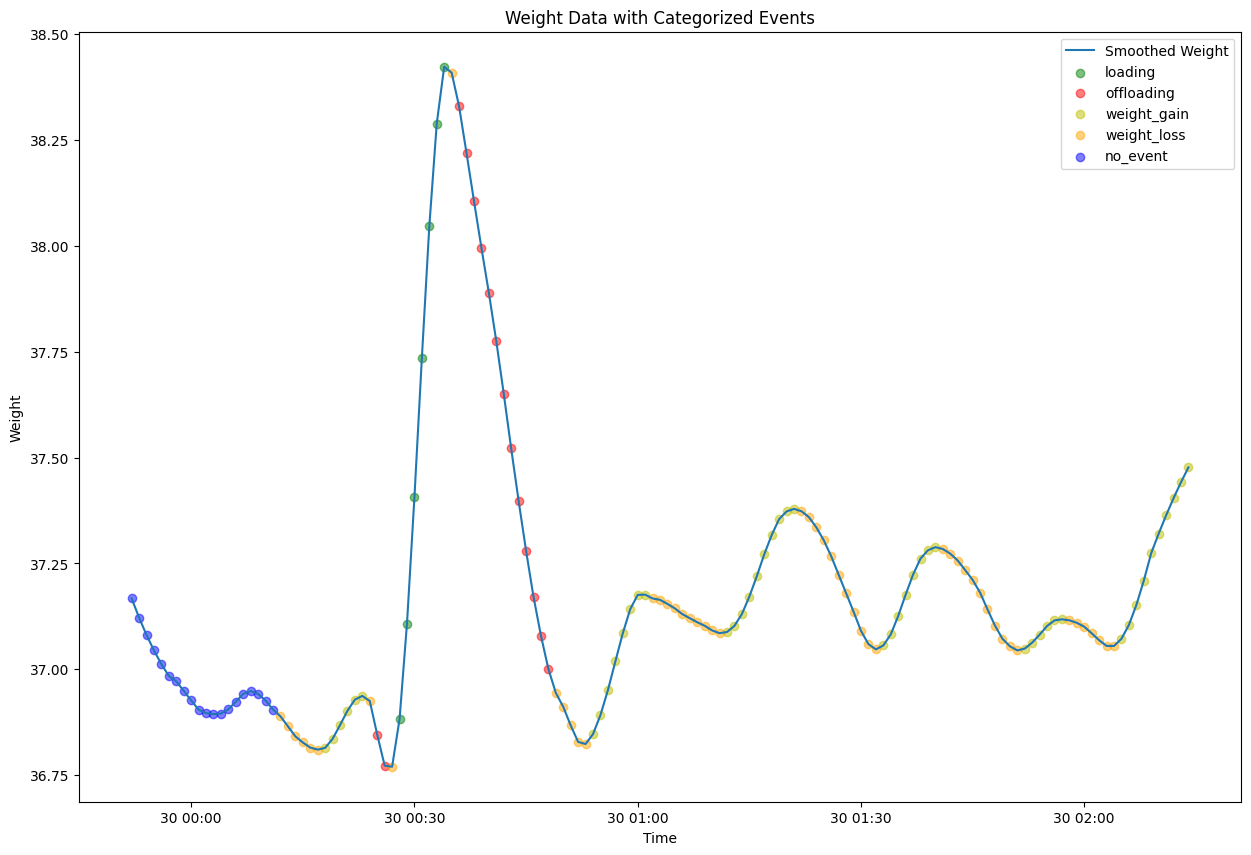

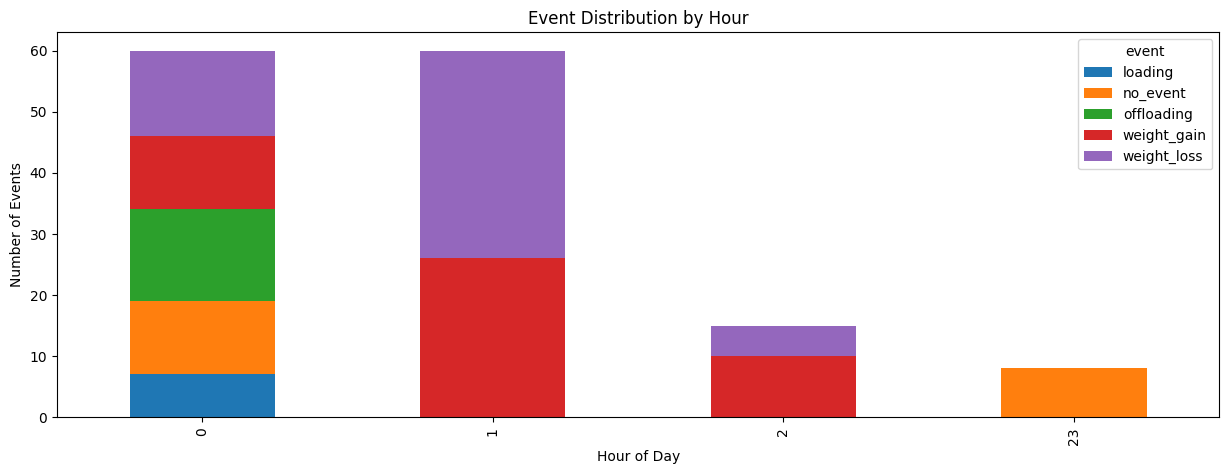

In [85]:
# Visualization without rf
plt.figure(figsize=(15, 10))
plt.plot(smoothed_df.index, smoothed_df['smoothed_weight'], label='Smoothed Weight')
event_colors = {'loading': 'g', 'offloading': 'r', 'weight_gain': 'y', 'weight_loss': 'orange', 'no_event': 'b'}

for event in event_colors:
    event_data = smoothed_df[smoothed_df['event'] == event]
    # Plot events in the middle of the window to reflect the rolling window nature
    plt.scatter(event_data.index, event_data['smoothed_weight'], c=event_colors[event], label=event, alpha=0.5)

plt.legend()
plt.title('Weight Data with Categorized Events')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.show()

# Time-based analysis
smoothed_df['hour'] = smoothed_df.index.hour
hourly_events = smoothed_df.groupby('hour')['event'].value_counts().unstack(fill_value=0)
hourly_events.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.title('Event Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.show()

In [ ]:
smoothed_df.head(275)
# Export to csv the new data
smoothed_df.to_csv('filtered_data.csv', index=False)

# We will me implementing random forests for classification
## After testing it was the most optimal model for now

In [86]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Create features
features = ['smoothed_weight', 'weight_diff', 'roc']
smoothed_df['event'] = smoothed_df['event'].fillna('no_event')
X = smoothed_df[features].fillna(0)
y = smoothed_df['event']

# Convert categorical labels to numerical labels
label_mapping = {'no_event': 0, 'weight_gain': 1, 'loading': 2, 'offloading': 3}
y = y.map(label_mapping)

# Drop any remaining NaN values in y after mapping
X = X[~y.isna()]
y = y.dropna()

# Check for NaN values in y after mapping
if y.isnull().any():
    print("There are still NaN values in y after mapping.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_rf_pred = rf_clf.predict(X_test)

# Check unique values in y_test
unique_classes = y_test.unique()

# Adjust the target names
filtered_label_mapping = {key: label_mapping[key] for key in label_mapping if label_mapping[key] in unique_classes}

# Evaluate the Random Forest model with the filtered target names
rf_report = classification_report(y_test, y_rf_pred, target_names=filtered_label_mapping.keys())
rf_report


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n    no_event       1.00      0.60      0.75         5\n weight_gain       0.70      1.00      0.82         7\n     loading       0.00      0.00      0.00         1\n  offloading       1.00      1.00      1.00         5\n\n    accuracy                           0.83        18\n   macro avg       0.68      0.65      0.64        18\nweighted avg       0.83      0.83      0.81        18\n'

## Save the model

In [87]:
import joblib

# Save the trained Random Forest model to a file
model_filename = 'random_forest_model.joblib'
joblib.dump(rf_clf, model_filename)


['random_forest_model.joblib']

# Make inferences with the model

In [88]:
model = joblib.load('random_forest_model.joblib')

# Ensure no NaN values in the features
smoothed_df['smoothed_weight'] = smoothed_df['smoothed_weight'].fillna(0)
smoothed_df['weight_diff'] = smoothed_df['weight_diff'].fillna(0)
smoothed_df['roc'] = smoothed_df['roc'].fillna(0)

# Select features for prediction
features = ['smoothed_weight', 'weight_diff', 'roc']
X = smoothed_df[features]

# Make predictions
predictions = model.predict(X)

# Convert numerical predictions back to categorical labels
label_mapping = {0: 'no_event', 1: 'weight_gain', 2: 'loading', 3: 'offloading'}
prediction_labels = [label_mapping[pred] for pred in predictions]

# Add the predictions to the DataFrame
smoothed_df['predictions_rf'] = prediction_labels

# Display the updated DataFrame
smoothed_df.head(40)

,weight,imei,smoothed_weight,windowed_weights,rolling_std,weight_diff,roc,event,hour,predictions_rf
datetime,,,,,,,,,,
2024-07-29 23:52:00,37.206667,8.694871e+14,37.167384,NaN,NaN,0.000000,0.000000,no_event,23,weight_gain
2024-07-29 23:53:00,37.077501,8.694871e+14,37.122015,NaN,NaN,-0.045369,-0.001221,no_event,23,no_event
2024-07-29 23:54:00,37.067501,8.694871e+14,37.080999,NaN,NaN,-0.041016,-0.001105,no_event,23,no_event
2024-07-29 23:55:00,37.047501,8.694871e+14,37.044336,NaN,NaN,-0.036663,-0.000989,no_event,23,no_event
2024-07-29 23:56:00,37.012501,8.694871e+14,37.012026,NaN,NaN,-0.032310,-0.000872,no_event,23,no_event
2024-07-29 23:57:00,36.987501,8.694871e+14,36.984069,NaN,NaN,-0.027957,-0.000755,no_event,23,no_event
2024-07-29 23:58:00,36.975001,8.694871e+14,36.971126,NaN,NaN,-0.012943,-0.000350,no_event,23,no_event
2024-07-29 23:59:00,36.947501,8.694871e+14,36.949063,NaN,NaN,-0.022063,-0.000597,no_event,23,no_event
2024-07-30 00:00:00,36.925001,8.694871e+14,36.926114,NaN,NaN,-0.022949,-0.000621,no_event,0,no_event


In [89]:
# save the df to csv
smoothed_df.to_csv('filtered_data_with_predictions.csv', index=False)


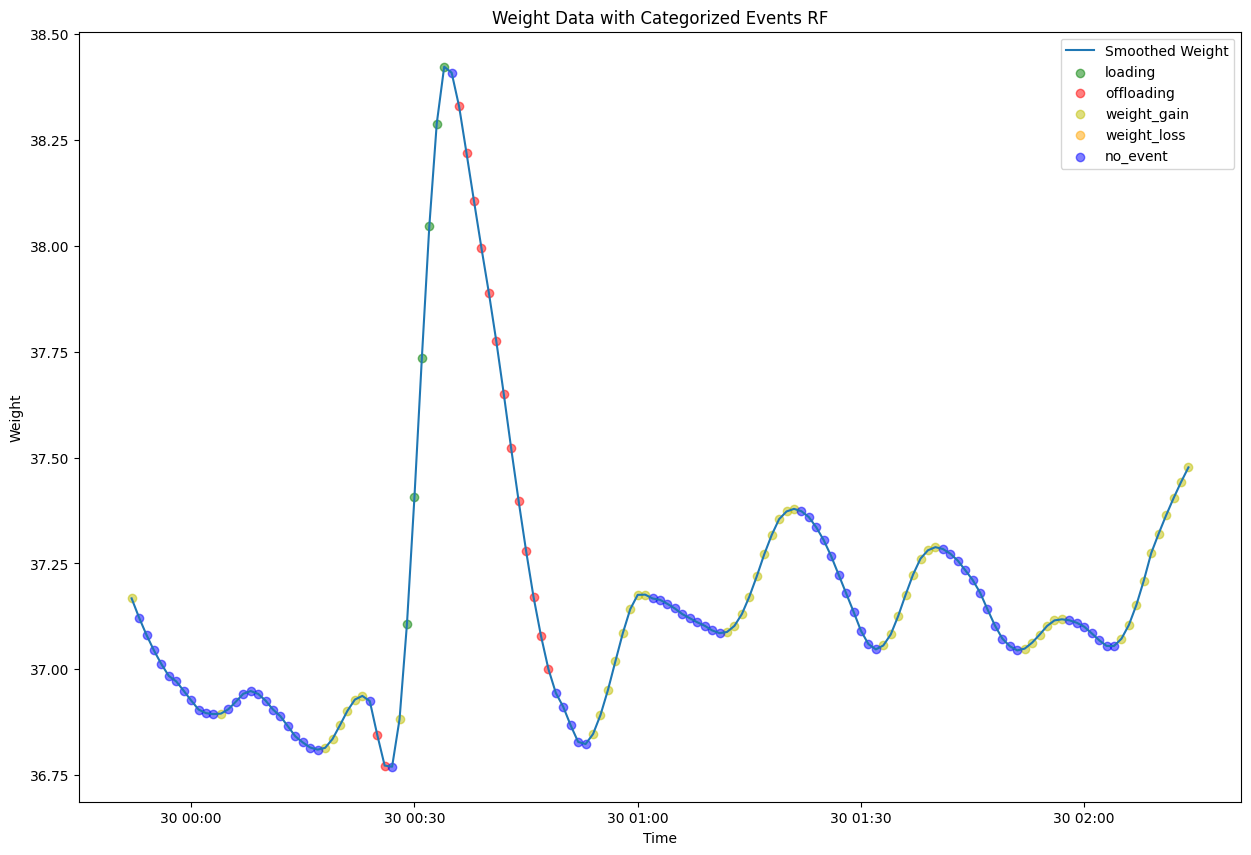

In [90]:

# Visualization rf
plt.figure(figsize=(15, 10))
plt.plot(smoothed_df.index, smoothed_df['smoothed_weight'], label='Smoothed Weight')
event_colors = {'loading': 'g', 'offloading': 'r', 'weight_gain': 'y', 'weight_loss': 'orange', 'no_event': 'b'}

for event in event_colors:
    event_data = smoothed_df[smoothed_df['predictions_rf'] == event]
    # Plot events in the middle of the window to reflect the rolling window nature
    plt.scatter(event_data.index, event_data['smoothed_weight'], c=event_colors[event], label=event, alpha=0.5)

plt.legend()
plt.title('Weight Data with Categorized Events RF')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.show()